# Redistricting - Rankin, MS School Board 

### Code used to generate a sample of redistricting plans that optimize for the creation of a coalition district

*************************

Draw a illustrative map that:
- keeping deviations under +4%. 
- consider the number of students when developing your new lines. 

Ideally:
- Decreases compactness score
- Decreases splits of VTDs and precincts
- Creates a coalition district of Asian and Hispanic population. 

Questions:
- Performance? estimate how any Gingles district might be able to perform as part of your illustrative map 
estimate of the number of students that may be serviced by each district and consider the number of students when developing your new lines. 


In [15]:
import maup
import pandas as pd
import geopandas as gp
import random
import warnings
warnings.filterwarnings('ignore')

**Load data**

In [16]:
current_dist = gp.read_file("./raw_data/current_districts/rankin_school_districts_2022.geojson")
# pearl = gp.read_file("./raw_data/current_districts/pearl-school-district.shp")
vtd_2020 = gp.read_file("./raw_data/tl_2020_28_vtd20/tl_2020_28_vtd20-rankin_county.shp")
# elec_2020 = pd.read_csv("./raw_data/Election_Data_MS.v05/election_data_MS.v05.csv")
blocks_2020 = gp.read_file("./raw_data/ms_pl2020_b/ms_pl2020_p1_b-rankin_county.shp")
cvap_2022 = pd.read_csv("./raw_data/ACS_2022/ms_cvap_2022_2020_b/ms_cvap_2022_2020_b.csv")
acs_race_2022 = gp.read_file("./raw_data/ACS_2022/ms_race_2022_bg/ms_race_2022_bg.shp")
acs_race_2022 = acs_race_2022[acs_race_2022['COUNTYFP'] == '121']
acs_poverty_2022 = pd.read_csv("./raw_data/ACS_2022/ms_pov_2022_bg/ms_pov_2022_bg.csv")
acs_educ_2022 = pd.read_csv("raw_data/ACS_2022/ms_edu_2022_bg/ms_edu_2022_bg.csv")

In [17]:
current_dist = current_dist.to_crs(epsg=4326)
# pearl = pearl.to_crs(epsg=4326)
vtd_2020 = vtd_2020.to_crs(epsg=4326)
blocks_2020 = blocks_2020.to_crs(epsg=4326)
acs_race_2022 = acs_race_2022.to_crs(epsg=4326)

current_dist["geometry"] = current_dist.buffer(0)
vtd_2020["geometry"] = vtd_2020.buffer(0)
blocks_2020["geometry"] = blocks_2020.buffer(0)
acs_race_2022['geometry'] = acs_race_2022.buffer(0)

### join CVAP data to blocks

In [18]:
cvap_2022.GEOID20 = cvap_2022.GEOID20.astype(str)
blocks_2020= blocks_2020.merge(cvap_2022, on='GEOID20', how='left')

### Prorate data from ACS 2022 Block-Groups to census blocks

In [19]:
# acs_race_2022
# acs_poverty_2022 
# acs_educ_2022

In [20]:
pop_columns = [col for col in acs_race_2022.columns if "22" in col]
bg_to_blocks_assignment = maup.assign(blocks_2020, acs_race_2022)
# Prorate the ACS totals according to each block's share of the overall block group population:
weights = blocks_2020.P0010001  / bg_to_blocks_assignment.map(blocks_2020.P0010001.groupby(bg_to_blocks_assignment).sum())#.fillna(0)
prorated = maup.prorate(bg_to_blocks_assignment, acs_race_2022[pop_columns], weights)

blocks_2020[pop_columns] = prorated

In [21]:
blocks_2020['CVAP_POC'] = blocks_2020[['CVAP_2OM22', 'CVAP_HSP22', 'CVAP_AIA22', 'CVAP_ASN22', 'CVAP_BLK22']].sum(axis=1)
blocks_2020['CVAP_COALITION'] = blocks_2020[['CVAP_HSP22', 'CVAP_ASN22']].sum(axis=1)

### Assign blocks to VTDs

In [22]:
vtd_assign = maup.assign(blocks_2020, vtd_2020)
blocks_2020['VTD'] = [vtd_2020.iloc[x]['VTDST20'] for x in vtd_assign.tolist()]

### Filter blocks to just Rankin School Board Area

<Axes: >

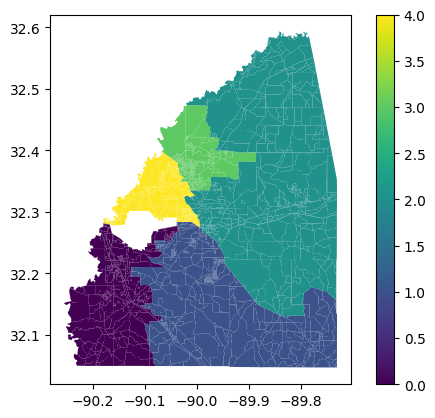

In [23]:
blocks_2020_rankin = blocks_2020[blocks_2020['current_di']!=5]
blocks_2020_rankin.plot(column='current_di', legend=True)

In [24]:
blocks_2020_rankin['TOT_POP22'].sum()

135082.03529294132

In [25]:
blocks_2020_rankin.groupby('current_di').TOT_POP22.sum()

current_di
0    28761.495834
1    25276.914366
2    25760.571977
3    27986.008391
4    27297.044725
Name: TOT_POP22, dtype: float64

In [26]:
blocks_2020_rankin.groupby('current_di').CVAP_TOT22.sum()

current_di
0    22272
1    19005
2    19560
3    20694
4    21136
Name: CVAP_TOT22, dtype: int64

### MCMC Prep

In [27]:
import networkx as nx
from functools import partial
import matplotlib.pyplot as plt
import json
import numpy as np
from statistics import mean
plt.style.use('ggplot')

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    GeographicPartition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import polsby_popper
from gerrychain.tree import bipartition_tree
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from gerrychain.proposals import recom
from gerrychain.updaters.locality_split_scores import LocalitySplits
from gerrychain.constraints import contiguous
from gerrytools.scoring import gingles_districts, demographic_shares, reock
random.seed(99)

Optional module 'mgrp' could not be imported: No module named 'docker'


In [28]:
state_abbr = "MS"
state_fip = "28"
num_districts = 5
unique_label = "GEOID20"
pop_col = "TOT_POP22"

In [29]:
blocks_2020_select = blocks_2020_rankin[['GEOID20', 'current_di', 'TOT_POP22', 'CVAP_TOT22', 'CVAP_POC', 'CVAP_COALITION', 'total_mi_1', 'VTD', 'geometry']]

In [30]:
# create graph
graph = Graph.from_geodataframe(blocks_2020_select)
graph.add_data(blocks_2020_select,list(blocks_2020_select))

/Users/kristenakey/.local/share/virtualenvs/rankin_school-board-tzA4L7yf/lib/python3.11/site-packages/gerrychain/graph/graph.py:266: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [31]:
### Custom updaters
class PartValue:
    def __init__(self, col=None, state=state_abbr, num=None):
        self.col = col
        self.state = state
        self.num = num

    def get_val(self, partition):
        return list(map(lambda x: partition.graph.nodes[x].get(self.col), graph.node_indices))
    
    def new_districts(partition):
        return list(map(lambda x: partition.assignment[x], graph.node_indices))
    
    def calc_reock(partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
            "GEOID20": geos_ids,
            "DIST": new_dist}
        )
        return reock().apply(blocks_2020[['GEOID20', 'geometry']].to_crs(epsg=5070).merge(assignment_df, on='GEOID20', how='left').dissolve(by='DIST'))
    

class SavePart:
    def __init__(self, state=state_abbr, num=None, dir = None):
        self.state = state
        self.num = num
        self.dir = dir
        
    def save_assignment(self, partition):
        geos_ids = PartValue(col='GEOID20').get_val(partition)
        new_dist = PartValue.new_districts(partition)
        assignment_df = pd.DataFrame({
                "GEOID20": geos_ids,
                "DIST": new_dist}
            )
        output_name = f"{self.state}_part_{str(self.num)}.txt",
        if self.dir is not None:
            output_name = f"{self.dir}/{self.state}_part_{str(self.num)}.txt"
        return(assignment_df.to_csv(output_name, index=False))


In [32]:
updater = {
    "population": updaters.Tally("TOT_POP22", alias="population"),
    "cvap": updaters.Tally("CVAP_TOT22", alias="cvap"),
    "cvap_poc": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "cvap_coalition": updaters.Tally("CVAP_POC", alias="cvap_poc"),
    "reock" : PartValue.calc_reock,
    "vtd_splits": LocalitySplits("vtd_splits", col_id='VTD', pop_col='TOT_POP22')
}

initial_partition = GeographicPartition(
    graph,
    assignment="current_di",
    updaters=updater
)

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col="TOT_POP22",
    pop_target=ideal_population,
    # epsilon=0.04,
    epsilon=0.1,
    node_repeats=2,
    method = partial(
        bipartition_tree,
        max_attempts=5,
        allow_pair_reselection=True 
    )
)

In [33]:
ideal_population

27016.40705858827

In [ ]:
# population check
TOTPOP = sum(graph.nodes()[n]['TOT_POP22'] for n in graph.nodes())
print(TOTPOP)
blocks_2020_rankin.TOT_POP22.sum()

### Optimize for plans that allow for a minority coalition district

In [ ]:
gingles_optimizer = Gingleator(
    proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    # minority_pop_col="cvap_coalition",
    minority_pop_col="cvap_poc",
    total_pop_col="population",
    score_function=Gingleator.reward_partial_dist
)

In [ ]:
init_vtd_split = init_vtd_split = list(initial_partition['vtd_splits'].values())[0]
init_reock = mean(initial_partition['reock'].values())
init_polsby = mean(polsby_popper(initial_partition).values())

In [ ]:
tot_pop = []
pop_dev = []
cvap_pop = []
cvap_poc = []
cvap_coalition = []

gingles_scores = []
poc_props = []

reock_min = []
reock_avg = []
polsby_popper_min = []
polsby_popper_avg = []

vtd_splits = []

t = 0
# with open("./output-gingles/MS_output.jsonl", "w") as f:
with open("./output-gingles/MS_output-all.jsonl", "w") as f:
    for i, part in enumerate(gingles_optimizer.short_bursts(5, 20000, with_progress_bar=True)):
        
        tot_pop.append(part["population"])
        cvap_pop.append(part["cvap"])
        cvap_poc.append(part["cvap_poc"])
        cvap_coalition.append(part["cvap_coalition"])
        
        dev = abs((min(part["population"].values()) / ideal_population) - (max(part["population"].values()) / ideal_population))
        pop_dev.append(dev)
        
        reock_min.append(min(part['reock'].values()))
        reock_score = mean(part['reock'].values())
        reock_avg.append(reock_score)
        
        polsby_popper_min.append(min(polsby_popper(part).values()))
        polsby_score = mean(polsby_popper(part).values())
        polsby_popper_avg.append(polsby_score)
        
        vtd_split = int(list(part['vtd_splits'].values())[0])
        vtd_splits.append(vtd_split)
        
        pp = demographic_shares({"cvap": ["cvap_poc"]})[0].apply(part)
        # gd = gingles_districts({"cvap": ["cvap_coalition"]}, threshold=0.5)[0].apply(part)
        gd = gingles_districts({"cvap": ["cvap_poc"]}, threshold=0.4)[0].apply(part)
        poc_props.append(pp)
        gingles_scores.append(gd)


        if dev <= .1 and gd > 0:
            SavePart(num=t, dir='./output-gingles/').save_assignment(part)
            print(t, gd, dev, vtd_split, round(reock_score, 4), round(polsby_score, 4), round(max(pp.values()), 4))

        data = {
            "step": t,
            "populations": part["population"],
            "vtd_splits": vtd_split,
            "reock_score": reock_score,
            "polsby_score": polsby_score,
            "cvap_poc_prop": pp,
            "cvap_coalition_tot": part["cvap_coalition"],
            "cvap_poc_tot": part["cvap_poc"],
            "cvap_tot": part["cvap"],
            "gingles_districts" : gd,
        }
            
        # Add newline character to separate entries in JSONL file
        f.write(json.dumps(data) + "\n")
        t +=1

*****************************

### Analyze sampled plans

**it is impossible to create any plan that allows for 50%+1 Asian and Hispanic or 50%+1 minority coalition district, even with a population deviation of up to 10%**

****************************

#### Load run stats in later (if kernel died/restarted)

In [137]:
import pandas as pd
import json

In [138]:
with open('./output-gingles/MS_output-all.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [152]:
# plans sorted by min area displacement with lowest pop deviation
l = []
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))
  gingles = d['gingles_districts'][0]
  compactness = d['polsby_score'][0]
  if gingles > 0 and dev <= 0.1:
    l.append({idx:compactness})

l.sort(key=lambda x: list(x.values()), reverse=True)
l[:10]

[{43908: 0.263728250180582},
 {38144: 0.26304334367710047},
 {41698: 0.2626017978761841},
 {40254: 0.26244046403138804},
 {29934: 0.2601714649385001},
 {60229: 0.25724133795514514},
 {38143: 0.25626928560112766},
 {71493: 0.2556579197430214},
 {76932: 0.25563951483903036},
 {29933: 0.2552257424215964}]

0.42323733862959284
0.4032682193839219
0.40831000868642026
0.4164582531742978
0.43861275059753185
0.4335262813929605
0.40957549912773794
0.40957549912773794
0.40062097409518516
0.4281912365744701


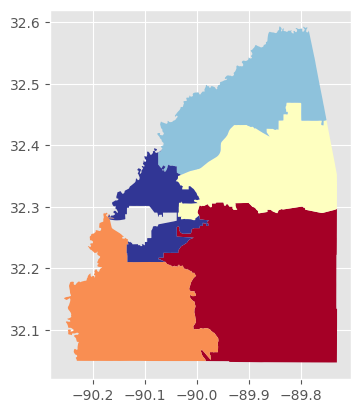

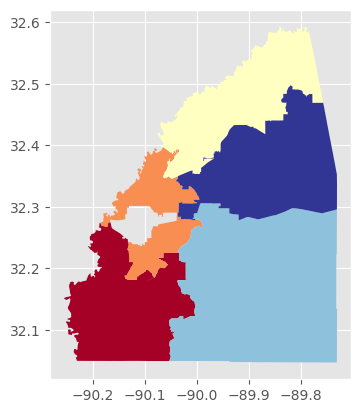

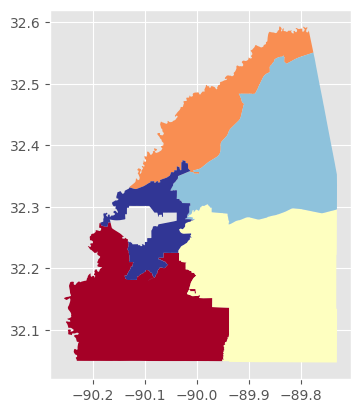

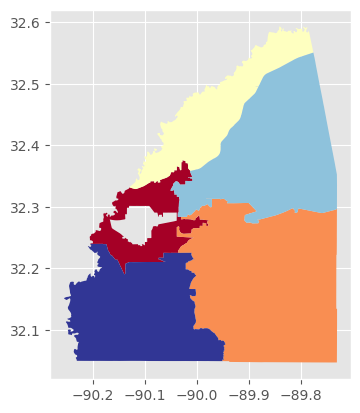

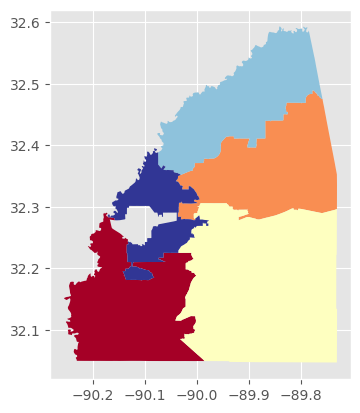

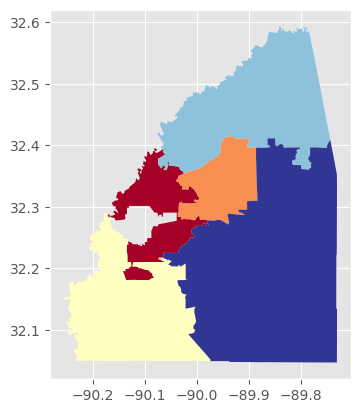

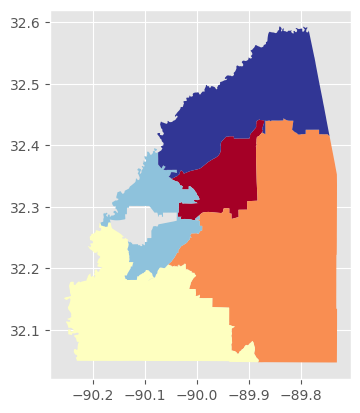

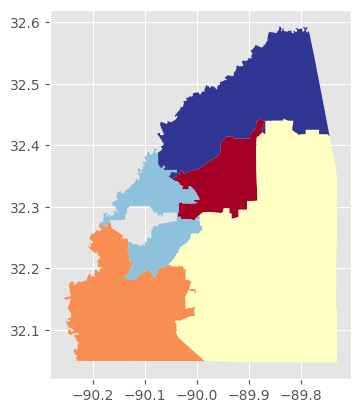

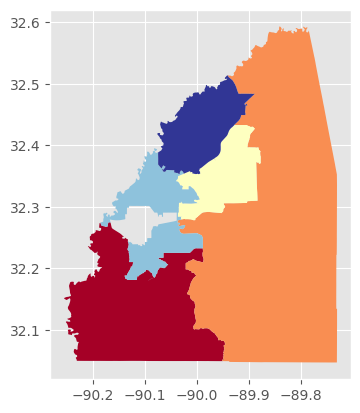

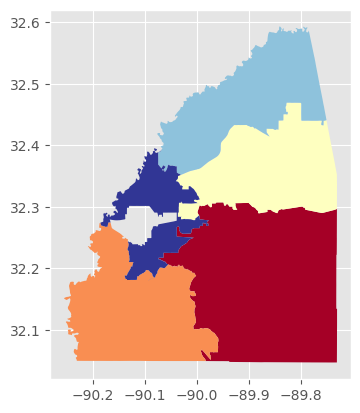

In [153]:
nums = list({k for d in l[:10] for k in d.keys()}) # extract keys (indices) from list

for num in nums:
  map = pd.read_csv(f'./output-gingles/MS_part_{num}.txt')
  map['GEOID20'] = map['GEOID20'].astype(str)
  d = pd.json_normalize(json.loads(json_list[num]))
  print(d[[i for i in d.columns if 'cvap_poc_prop' in i]].max().sort_values(ascending=False)[0])
  blocks_2020.merge(map, on='GEOID20', how='left').dissolve('DIST').plot(column='current_di', cmap='RdYlBu', color='black')

0.4164582531742978
0    0.257241
Name: polsby_score, dtype: float64
0    0.41427
Name: reock_score, dtype: float64
0    73
Name: vtd_splits, dtype: int64
0.40957549912773794
0    0.255226
Name: polsby_score, dtype: float64
0    0.400929
Name: reock_score, dtype: float64
0    74
Name: vtd_splits, dtype: int64


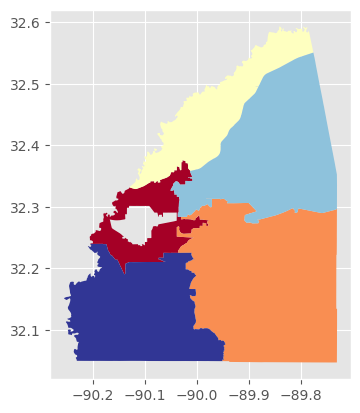

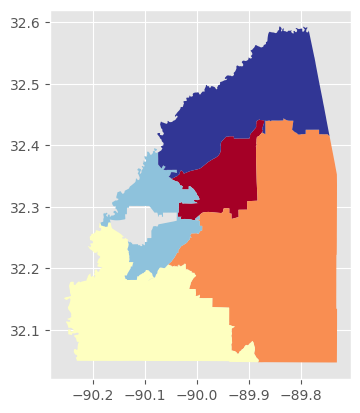

In [156]:
nums = [60229, 29933]

for num in nums:
  map = pd.read_csv(f'./output-gingles/MS_part_{num}.txt')
  map['GEOID20'] = map['GEOID20'].astype(str)
  d = pd.json_normalize(json.loads(json_list[num]))
  print(d[[i for i in d.columns if 'cvap_poc_prop' in i]].max().sort_values(ascending=False)[0])
  print(d['polsby_score'])
  print(d['reock_score'])
  print(d['vtd_splits'])
  blocks_2020.merge(map, on='GEOID20', how='left').dissolve('DIST').plot(column='current_di', cmap='RdYlBu', color='black')

In [126]:
# strongest influnece district that maintains population deviation
l = []
for idx, i in enumerate(json_list):
  d = pd.json_normalize(json.loads(json_list[idx]))
  pops = dict(d[[i for i in d.columns if "population" in i]].loc[0]).values()
  dev = abs((min(pops) / ideal_population) - (max(pops) / ideal_population))
  if dev <= 0.04:
    l.append({idx:d[[i for i in d.columns if 'cvap_poc_prop' in i]].max().sort_values(ascending=False)[0]})

In [127]:
l.sort(key=lambda x: list(x.values()), reverse=True)
l[:10]

[{88667: 0.45966291070921317},
 {74298: 0.44696470588235293},
 {20082: 0.44215263453965875},
 {77142: 0.4413865346157509},
 {82303: 0.438039383969866},
 {84471: 0.4368946005562482},
 {84093: 0.43521453238090735},
 {96664: 0.43477445371846574},
 {86912: 0.4346759739647203},
 {86221: 0.43432063939821347}]

0.45966291070921317
0.44696470588235293
0.44215263453965875
0.4413865346157509
0.438039383969866
0.4368946005562482
0.43521453238090735
0.43477445371846574
0.4346759739647203
0.43432063939821347


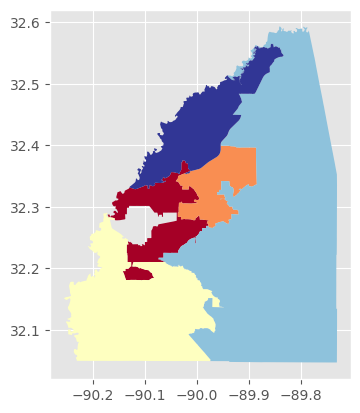

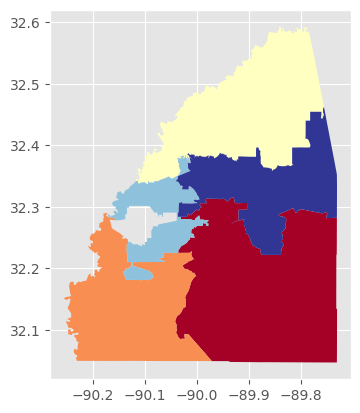

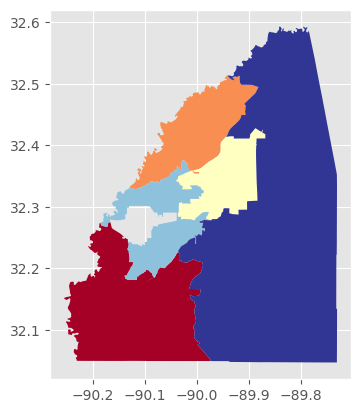

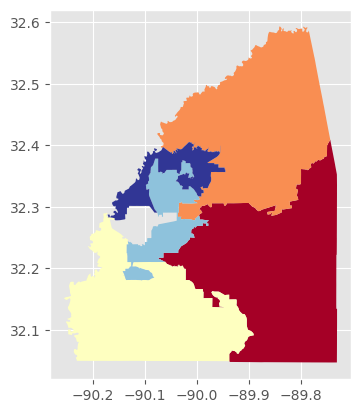

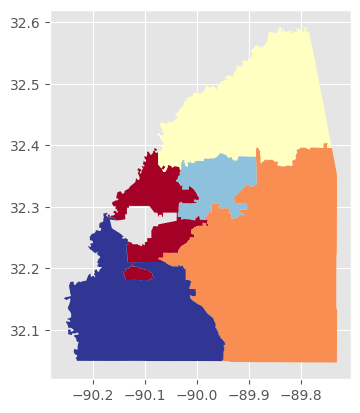

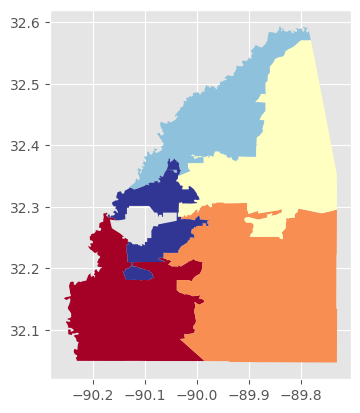

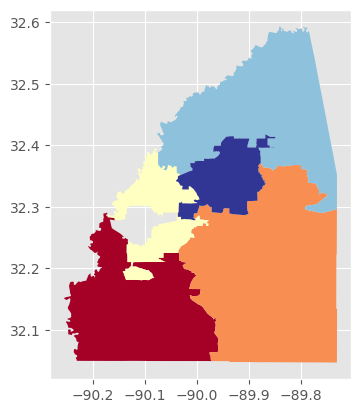

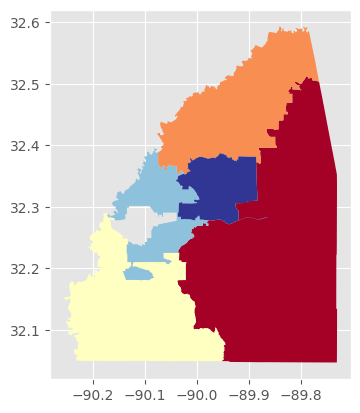

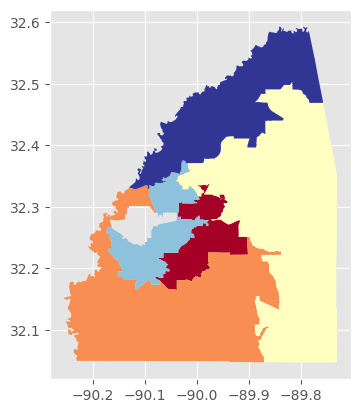

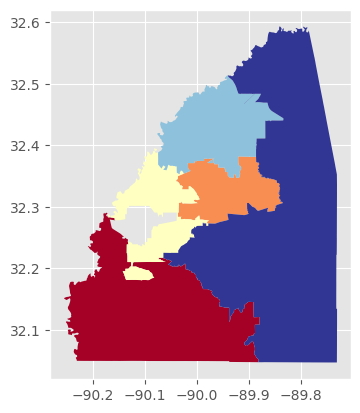

In [145]:
nums = list({k for d in l[:10] for k in d.keys()}) # extract keys (indices) from list

for num in nums:
  map = pd.read_csv(f'./output-gingles/MS_part_{num}.txt')
  map['GEOID20'] = map['GEOID20'].astype(str)
  d = pd.json_normalize(json.loads(json_list[num]))
  print(d[[i for i in d.columns if 'cvap_poc_prop' in i]].max().sort_values(ascending=False)[0])
  blocks_2020.merge(map, on='GEOID20', how='left').dissolve('DIST').plot(column='current_di', cmap='RdYlBu', color='black')